In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter

In [4]:
df = pd.read_csv('./../../the-movies-dataset-short/credits_short.csv', encoding ='utf-8')
number_of_movies = len(df.index)

In [5]:
def get_actors(movie_cast):
    cast_list = []
    for cast_object in movie_cast:
        cast_list.append(cast_object['name'])
    return cast_list


def list_all_actors():
    l = []
    for i, movie_id in enumerate(df['id'], start = 0):
        try:
            cast = df.loc[df['id']==movie_id]['cast'].item()
            cast_objects = ast.literal_eval(cast)
            list_of_actors = get_actors(cast_objects)
            l = l + list_of_actors
        except:
            pass
    return l
def list_actors_in_multiple_movies():
    l = list_all_actors()
    cnt = Counter(l)
    return ([k for k, v in cnt.items() if v > 1])
    

In [10]:
# Warning! Takes forever to run!
movies_network = nx.Graph()
errors = []
for i, movie_id in enumerate(df['id'], start = 0):
    if not i % 100: 
        print (str((i/number_of_movies)*100) +'% done')
    try:
        cast = df.loc[df['id']==movie_id]['cast'].item()
        cast_objects = ast.literal_eval(cast)
        movies_network.add_node(movie_id)
        list_of_actors = get_actors(cast_objects)
        #Find movies who share at least one actor
        for other_movie in df['id']:
            try:
                cast_other_movie = df.loc[df['id']==other_movie]['cast'].item()
                cast_objects_other_movie = ast.literal_eval(cast_other_movie)
                actors = get_actors(cast_objects_other_movie)
                if (set(list_of_actors) & set(actors)):
                    movies_network.add_node(other_movie)
                    movies_network.add_edge(other_movie, movie_id)
            except: 
                errors.append(['error in other movie with id: '+ (other_movie)])
    except:
        errors.append(['error in movie with id: '+ str(movie_id)])

0.0% done
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.000000000000001% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.000000000000002% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.000000000000004% done
28.999999999999996% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.00000000000001% done
56.00000000000001% done
56.99999999999999% done
57.99999999999999% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done


/Users/marita/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


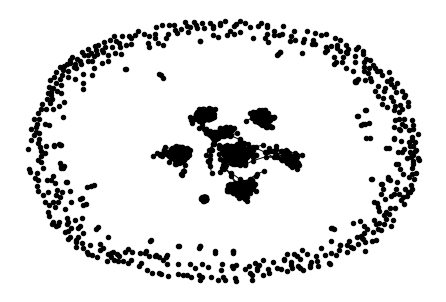

In [14]:
options = {'node_color': 'black',  
           'node_size': 20,
           'width': 1,}
nx.draw_spring(movies_network, **options)

In [8]:
actors_network = nx.Graph()
actors_to_include = list_actors_in_multiple_movies()
errors4 = []
for i, movie_id in enumerate(df['id'], start = 0):
    if not i % 100: 
         print(str((i/number_of_movies)*100) +'% done')
    try:
        cast = df.loc[df['id']==movie_id]['cast'].item()
        cast_objects = ast.literal_eval(cast)
        list_of_actors = get_actors(cast_objects)
        for index, actor1 in enumerate(list_of_actors,start = 0):
            if (actor1 in actors_to_include):
                if not actor1 in actors_network: 
                    actors_network.add_node(actor1)
                for actor2 in list_of_actors[index:]:
                    if (actor2 in actors_to_include):
                        if not actor2 in actors_network: 
                            actors_network.add_node(actor2)
                        actors_network.add_edge(actor1, actor2)
    except:
        errors4.append(['error in movie with id: '+ str(movie_id)])

0.0% done
2.0% done
4.0% done
6.0% done
8.0% done
10.0% done
12.0% done
14.000000000000002% done
16.0% done
18.0% done
20.0% done
22.0% done
24.0% done
26.0% done
28.000000000000004% done
30.0% done
32.0% done
34.0% done
36.0% done
38.0% done
40.0% done
42.0% done
44.0% done
46.0% done
48.0% done
50.0% done
52.0% done
54.0% done
56.00000000000001% done
57.99999999999999% done
60.0% done
62.0% done
64.0% done
66.0% done
68.0% done
70.0% done
72.0% done
74.0% done
76.0% done
78.0% done
80.0% done
82.0% done
84.0% done
86.0% done
88.0% done
90.0% done
92.0% done
94.0% done
96.0% done
98.0% done


In [ ]:
actors_network.number_of_nodes()

In [ ]:
options = {'node_color': 'black',  
           'node_size': 10,
           'width': 1,}
nx.draw_spring(actors_network, **options)

In [ ]:
def get_directors(movie_crew):
    directors_list = []
    for crew_object in movie_cast:
        if (crew_object['job'] == 'Director' || crew_object['job'] == 'Assistant Director'):
            directors_list.append(crew_object['name'])
    return directors_list


def list_all_directors():
    l = []
    for i, movie_id in enumerate(df['id'], start = 0):
        try:
            crew = df.loc[df['id']==movie_id]['crew'].item()
            crew_objects = ast.literal_eval(crew)
            list_of_directors = get_directors(crew_objects)
            l = l + list_of_directors
        except:
            pass
    return l

In [ ]:
directors_network = nx.Graph()
errors_directors = []
for i, movie_id in enumerate(df['id'], start = 0):
    if not i % 100: 
         print(str((i/number_of_movies)*100) +'% done')
    try:
        crew = df.loc[df['id']==movie_id]['crew'].item()
        crew_objects = ast.literal_eval(crew)
        list_of_directors = get_directors(crew_objects)
        for index, director1 in enumerate(list_of_directors,start = 0):
            if not director1 in directors_network: 
                directors_network.add_node(director1)
            for directors2 in list_of_directors[index:]:
                if not directors2 in directors_network: 
                    directors_network.add_node(directors2)
                directors_network.add_edge(directors1, directors2)
    except:
        errors_directors.append(['error in movie with id: '+ str(movie_id)])